In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator
import os
from PIL import Image

SAM with maximum confidence score filtering:

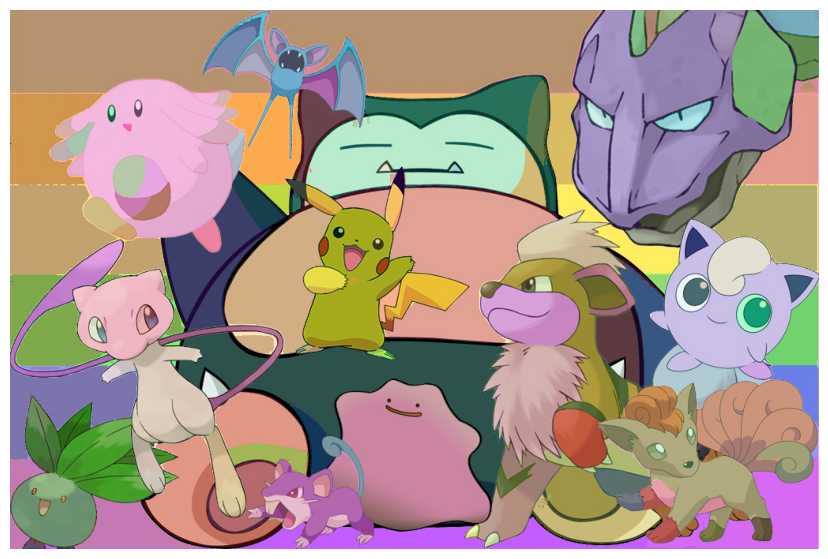

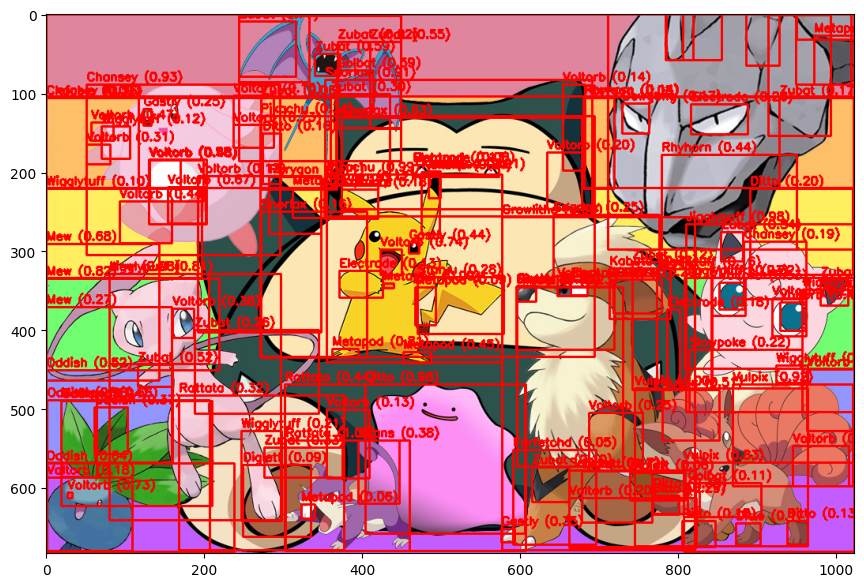

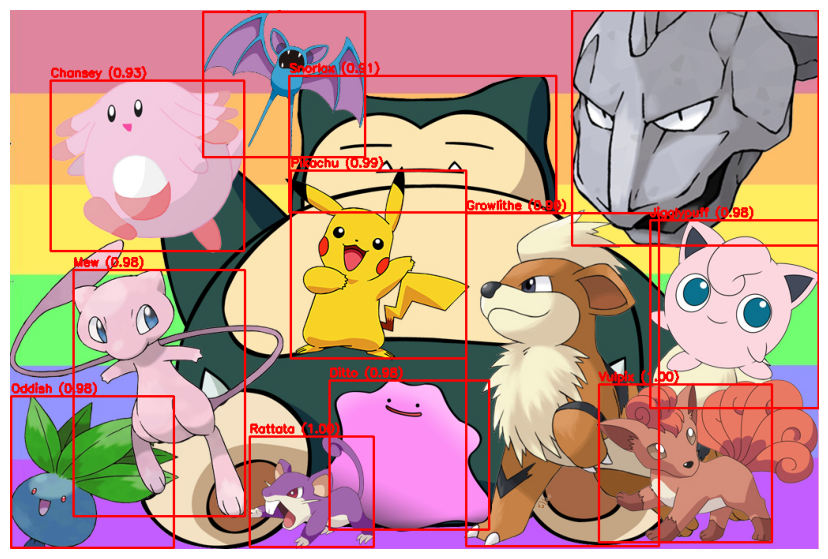

In [51]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def draw_boxes(image_path, boxes, labels, confidences):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for box, label, conf in zip(boxes, labels, confidences):
        x1, y1, x2, y2 = map(int, box)  # Convert the box coordinates to integers
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = f"{label} ({conf:.2f})"
        cv2.putText(image, text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

def predictbox(image, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = image.convert('RGB')
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(image).unsqueeze(0)
  

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, max_idx = torch.max(probabilities, dim=1)

    predicted_class = class_names[max_idx.item()]
    confidence = max_prob.item()

    return predicted_class, confidence

# change to the path where the best classifier model is saved:
# model_path = "/Users/nahaleh/Downloads/courses/Deep Learning/Project Report/pokemon_classifier_best.pth"
model_path = "./pokemon_classifier_best.pth"
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
num_classes = 150  
model.fc = torch.nn.Linear(num_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Load the class names
# change to training data directory:
# train_data_dir = "/Users/nahaleh/Downloads/courses/Deep Learning/Project Report/images"
train_data_dir = "./Train"
class_names = sorted(os.listdir(train_data_dir))

# Enter test image path below:
# input_image_path  = '/Users/nahaleh/Downloads/courses/Deep Learning/Project Report/test/mix11.jpg'
input_image_path = "./test/mix11.jpg"
image = cv2.imread(input_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# change path to where the SAM model is saved:
# sam_path = "/Users/nahaleh/Downloads/courses/Deep Learning/Project Report/sam_vit_h_4b8939.pth"
sam_path = "./sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_path)
mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=20,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
masks = mask_generator.generate(image)

plt.figure(figsize=(12,7))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

boxes, labels, confidences = [], [], []
for msk in masks:
    box = msk['bbox']
    x1, y1, w, h = map(int, box)
    x2 = x1+w
    y2 = y1+h
    cropped_image = Image.open(input_image_path).convert('RGB').crop((x1, y1, x2, y2))
    # cropped_image = image[y2:y1, x2:x1]
    predicted_class, confidence = predictbox(cropped_image, model, class_names)
    boxes.append([x1, y1, x2, y2])
    labels.append(predicted_class)
    confidences.append(confidence)

output_image = draw_boxes(input_image_path, boxes, labels, confidences)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.imshow(output_image)
plt.show()

# Define the thresholds for special classes
special_thresholds = {
    "Metapod": 0.98,
    "Voltorb": 0.95,
    "Kabuto": 0.8,
    "Voltorb": 0.98
    # Add more special classes here, e.g., "SpecialClass": 0.9,
}

filtered_boxes, filtered_labels, filtered_confidences = [], [], []

for box, label, conf in zip(boxes, labels, confidences):
    threshold = special_thresholds.get(label, 0.85)  # Default threshold



    if conf > threshold:
        filtered_boxes.append(box)
        filtered_labels.append(label)
        filtered_confidences.append(conf)
        # Find the maximum confidence box for each class

max_conf_per_class = {}
for i, conf in enumerate(filtered_confidences):
    label = filtered_labels[i]
    if label not in max_conf_per_class or conf > max_conf_per_class[label][0]:
        max_conf_per_class[label] = (conf, i)

# Extract the filtered boxes, labels, and confidences using the indices
max_indices = [val[1] for val in max_conf_per_class.values()]
max_boxes = [filtered_boxes[i] for i in max_indices]
max_labels = [filtered_labels[i] for i in max_indices]
max_confidences = [filtered_confidences[i] for i in max_indices]


final_output_image = draw_boxes(input_image_path, max_boxes, max_labels, max_confidences)
plt.figure(figsize=(12,7))
plt.imshow(final_output_image)
plt.axis('off')
plt.show()